In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
def extract_plate(img): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    
    #Loads the data required for detecting the license plates from cascade classifier.
    plate_cascade = cv2.CascadeClassifier('./indian_license_plate.xml')

    # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.3, minNeighbors = 7)

    for (x,y,w,h) in plate_rect:
        a,b = (int(0.02*img.shape[0]), int(0.025*img.shape[1])) #parameter tuning
        plate = plate_img[y+a:y+h-a, x+b:x+w-b, :]
        # finally representing the detected contours by drawing rectangles around the edges.
        cv2.rectangle(plate_img, (x,y), (x+w, y+h), (51,51,255), 3)
    
    cv2.imwrite("frame4.jpg",plate_img)
    cv2.imwrite("frame5.jpg",plate)

    
    #return plate_img, plate # returning the processed image.

img = cv2.imread("mer.jpeg", cv2.IMREAD_COLOR)
extract_plate(img)

In [3]:
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from keras.models import Sequential,model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
import tensorflow.keras.backend as K

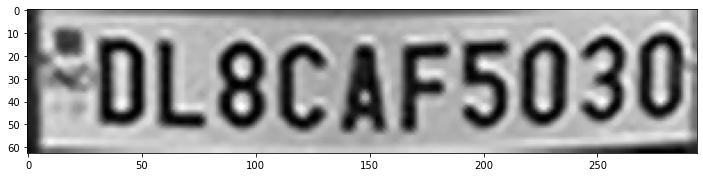

In [4]:
gray = cv2.imread("frame5.jpg", 0)
gray = cv2.resize( gray, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
blur = cv2.GaussianBlur(gray, (5,5), 0)
gray = cv2.medianBlur(gray, 3)
plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

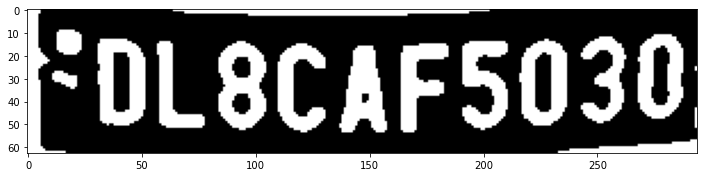

In [5]:
ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
#cv2.imshow("Otsu", thresh)
#cv2.waitKey(0)
plt.figure(figsize=(12, 10))
plt.imshow(thresh, cmap='gray')

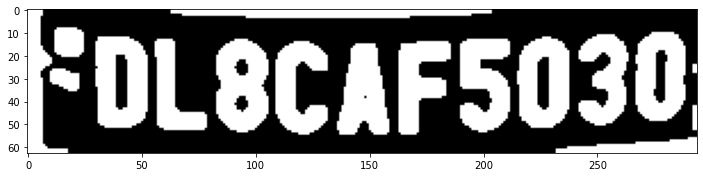

In [6]:
rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

# apply dilation 
dilation = cv2.dilate(thresh, rect_kern, iterations = 1)
#cv2.imshow("dilation", dilation)
#cv2.waitKey(0)
plt.figure(figsize=(12, 10))
plt.imshow(dilation, cmap='gray')


In [7]:
try:
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
except:
    ret_img, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

# create copy of image
im2 = gray.copy()


In [8]:
count =0
for cnt in sorted_contours:
    count=count+1
    x,y,w,h = cv2.boundingRect(cnt)
    height, width = im2.shape
    
    # draw the rectangle
    rect = cv2.rectangle(im2, (x,y), (x+w, y+h), (0,255,0),2)
    #cv2.imshow("rect", rect)
    #cv2.waitKey(0)
    roi = thresh[y:y+h, x:x+w]
    cv2.imwrite(f'{count}.png',roi)
    size_img=Image.open(f'{count}.png')
    width, height = size_img.size
    size_img.close()
    print(width, height)
    if(width<20 or width>40):
        os.remove(f'{count}.png')
        count=count-1
    #else:
    # cv2.imshow("rect", roi)
    # cv2.waitKey(0)

18 63
13 10
13 13
23 40
7 26
23 40
141 4
23 41
8 9
8 9
23 41
23 40
3 3
23 41
22 41
23 40
7 25
62 7
22 40
22 39
8 25
2 11
2 4


In [9]:
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./{}.h5".format(model_name))
    return model

In [10]:
pre_trained_model = load_keras_model('model_LicensePlate')
model = pre_trained_model 

In [11]:
print(pre_trained_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       131200    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3

In [14]:
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img 
    return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c
    output = []
    for i in range(1,11):
      ch = cv2.imread(f'{i}.png', 0)
      img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
      img = fix_dimension(img_)
      img = img.reshape(1,28,28,3) #preparing image for the model
      y_ = model.predict_classes(img)[0] #predicting the class
      character = dic[y_] #
      #storing the result in a list
      output.append(character)   
      plate_number = character
    plate_number = ''.join(output)
    return plate_number

print(show_results())

DL8CAF5030
